In [6]:
cd /content/drive/My Drive/University/SEM7/CS4622_Machine_Learning/Project_1/Fair_Classification/

/content/drive/My Drive/University/SEM7/CS4622_Machine_Learning/Project_1/Fair_Classification


# Import Statements

In [0]:
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians,asin
import folium
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
from folium.plugins import TimestampedGeoJson
from folium.plugins import MarkerCluster
from geopy.distance import great_circle
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle
from geopy.distance import geodesic

# Load Data

In [0]:
train  = pd.read_csv("/content/drive/My Drive/University/SEM7/CS4622_Machine_Learning/Project_1/Fair_Classification/train.csv")
test  = pd.read_csv("/content/drive/My Drive/University/SEM7/CS4622_Machine_Learning/Project_1/Fair_Classification/test.csv")

In [0]:
print (train[train.label == 'incorrect'].shape[0])

In [0]:
train.info()

In [0]:
test.describe()

# Data Claening

## Z score normalize

In [0]:
cols = ['additional_fare', 'meter_waiting_fare','fare', 'duration','meter_waiting','meter_waiting_till_pickup']
for col in cols:
    mean = train[col].mean()
    std = train[col].std(ddof=0)
    train[col] = (train[col] - mean)/std

for col in cols:
    mean = test[col].mean()
    std = test[col].std(ddof=0)
    test[col] = (test[col] - mean)/std

## Flag Outliers

In [0]:
print('Old size: %d' % len(train))
mean, std  =train.additional_fare.mean() , train.additional_fare.std()
train['additional_fare_is_outlier'] = train['additional_fare'].apply(lambda x: 0 if (np.abs(x-mean) <= (3*std)) else 1)
test['additional_fare_is_outlier'] = test['additional_fare'].apply(lambda x: 0 if (np.abs(x-mean) <= (3*std)) else 1)
print('New size: %d' % len(train))
print (train[train.additional_fare_is_outlier == 1].shape[0])
print (train[train.label == 'incorrect'].shape[0])

Old size: 17176
New size: 17176
204
1681


In [0]:
print('Old size: %d' % len(train))
mean, std  =train.meter_waiting_fare.mean() , train.meter_waiting_fare.std()
train['meter_waiting_fare_is_outlier'] = train['meter_waiting_fare'].apply(lambda x: 0 if (np.abs(x-mean) <= (3*std)) else 1)
test['meter_waiting_fare_is_outlier'] = test['meter_waiting_fare'].apply(lambda x: 0 if (np.abs(x-mean) <= (3*std)) else 1)
print('New size: %d' % len(train))
print (test[test.meter_waiting_fare_is_outlier == 1].shape[0])
print (train[train.label == 'incorrect'].shape[0])

Old size: 17176
New size: 17176
22
1681


In [0]:
print('Old size: %d' % len(train))
mean, std  =train.fare.mean() , train.fare.std()
train['fare_is_outlier'] = train['fare'].apply(lambda x: 0 if ((np.abs(x-mean) <= (3*std)) or x<=0 ) else 1)
test['fare_is_outlier'] = test['fare'].apply(lambda x: 0 if ((np.abs(x-mean) <= (3*std)) or x<=0 ) else 1)
print('New size: %d' % len(train))
print (train[train.fare_is_outlier == 1].shape[0])
print (train[train.label == 'incorrect'].shape[0])

Old size: 17176
New size: 17176
225
1681


## Drop outliers

In [0]:
print('Old size: %d' % len(train))
train = train[np.abs(train.duration-train.duration.mean()) <= (3*train.duration.std())]
print('New size: %d' % len(train))
print (train[train.label == 'incorrect'].shape[0])

Old size: 17176
New size: 16920
1485


In [0]:
print('Old size: %d' % len(train))
train = train[np.abs(train.meter_waiting_till_pickup	-train.meter_waiting_till_pickup.mean()) <= (3*train.meter_waiting_till_pickup.std())]
print('New size: %d' % len(train))
print (train[train.label == 'incorrect'].shape[0])

Old size: 16920
New size: 16906
1479


In [0]:
print('Old size: %d' % len(train))
train = train[np.abs(train.meter_waiting-train.meter_waiting.mean()) <= (3*train.meter_waiting.std())]
print('New size: %d' % len(train))
print (train[train.label == 'incorrect'].shape[0])

Old size: 16906
New size: 16858
1454


## Format date and Lables

In [0]:
train['pickup_time']=pd.to_datetime(train['pickup_time'],infer_datetime_format=True)
train['drop_time']=pd.to_datetime(train['drop_time'],infer_datetime_format=True)

test['pickup_time']=pd.to_datetime(test['pickup_time'],infer_datetime_format=True)
test['drop_time']=pd.to_datetime(test['drop_time'],infer_datetime_format=True)

In [0]:
train['pickup_date']= train['pickup_time'].dt.date
train['pickup_day']=train['pickup_time'].apply(lambda x:x.day)
train['pickup_hour']=train['pickup_time'].apply(lambda x:x.hour)
train['pickup_day_of_week']=train['pickup_time'].apply(lambda x:calendar.day_name[x.weekday()])
train['pickup_month']=train['pickup_time'].apply(lambda x:x.month)
train['pickup_year']=train['pickup_time'].apply(lambda x:x.year)

test['pickup_date']= test['pickup_time'].dt.date
test['pickup_day']=test['pickup_time'].apply(lambda x:x.day)
test['pickup_hour']=test['pickup_time'].apply(lambda x:x.hour)
test['pickup_day_of_week']=test['pickup_time'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_month']=test['pickup_time'].apply(lambda x:x.month)
test['pickup_year']=test['pickup_time'].apply(lambda x:x.year)

In [0]:
def encodeDays(day_of_week):
  day_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
  return day_dict[day_of_week]
def encodeLabel(label):
  label_dict={'correct':1,'incorrect':0}
  return label_dict[label]
def clean_data(data,isTrain):
  data['pickup_day_of_week']=data['pickup_day_of_week'].apply(lambda x:encodeDays(x))
  if(isTrain):
    data['label']=data['label'].apply(lambda x:encodeLabel(x))
  return data

In [14]:
train=clean_data(train,True)
test=clean_data(test,False)
print("Shape of Training Data after cleaning ",train.shape)
print("Shape of Testing Data after cleaning", test.shape)


Shape of Training Data after cleaning  (17176, 20)
Shape of Testing Data after cleaning (8576, 19)


# EDA

In [0]:
test[pd.isnull(test)].sum()

tripid                           0.0
additional_fare                  0.0
duration                         0.0
meter_waiting                    0.0
meter_waiting_fare               0.0
meter_waiting_till_pickup        0.0
pickup_time                      0.0
drop_time                        0.0
pick_lat                         0.0
pick_lon                         0.0
drop_lat                         0.0
drop_lon                         0.0
fare                             0.0
additional_fare_is_outlier       0.0
meter_waiting_fare_is_outlier    0.0
fare_is_outlier                  0.0
pickup_date                      0.0
pickup_day                       0.0
pickup_hour                      0.0
pickup_day_of_week               0.0
pickup_month                     0.0
pickup_year                      0.0
dtype: float64

## Trip Fare Analysis

Text(0.5, 1.0, 'Distribution of Trip Fare')

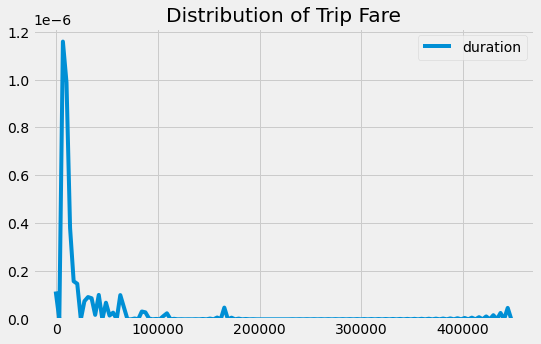

In [0]:
plt.figure(figsize=(8,5))
sns.kdeplot(test['duration']).set_title("Distribution of Trip Fare")

In [0]:
train.loc[train['meter_waiting_till_pickup']<0].shape

(0, 23)

Text(0.5, 1.0, 'Distribution of fare amount (log scale)')

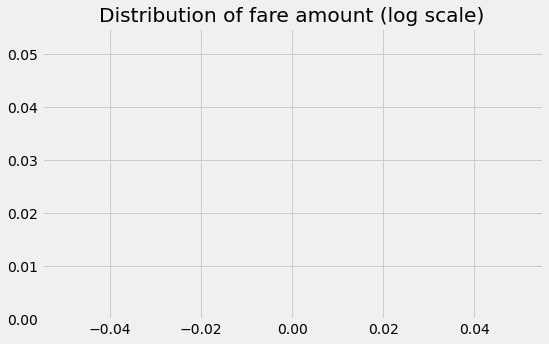

In [0]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['fare'].values)).set_title("Distribution of fare amount (log scale)")

## Pickup Location Analysis

In [0]:
print("Range of pickup Longitude is ", (min(test['pick_lon']),max(test['pick_lon'])))
print("Range of Pickup Latitude is ", (min(test['pick_lat']),max(test['pick_lat'])))
test[(test.pick_lat==0) | (test.pick_lon)==0 | (test.drop_lat==0)|(test.drop_lon==0)].shape

Range of pickup Longitude is  (79.8177, 80.7764)
Range of Pickup Latitude is  (5.94313, 8.42501)


(0, 22)

In [0]:
boundary={'min_lng':79.818,
              'min_lat':5.94313,
              'max_lng':80.8055, 
              'max_lat':8.42501}

In [0]:
train.loc[~((train.pick_lon >= boundary['min_lng'] ) & (train.pick_lon <= boundary['max_lng']) &
            (train.pick_lat >= boundary['min_lat']) & (train.pick_lat <= boundary['max_lat']) &
            (train.drop_lon >= boundary['min_lng']) & (train.drop_lon <= boundary['max_lng']) &
            (train.drop_lat >=boundary['min_lat']) & (train.drop_lat <= boundary['max_lat'])),'is_outlier_loc']=1
train.loc[((train.pick_lon >= boundary['min_lng'] ) & (train.pick_lon <= boundary['max_lng']) &
            (train.pick_lat >= boundary['min_lat']) & (train.pick_lat <= boundary['max_lat']) &
            (train.drop_lon >= boundary['min_lng']) & (train.drop_lon <= boundary['max_lng']) &
            (train.drop_lat >=boundary['min_lat']) & (train.drop_lat <= boundary['max_lat'])),'is_outlier_loc']=0

test.loc[~((test.pick_lon >= boundary['min_lng'] ) & (test.pick_lon <= boundary['max_lng']) &
            (test.pick_lat >= boundary['min_lat']) & (test.pick_lat <= boundary['max_lat']) &
            (test.drop_lon >= boundary['min_lng']) & (test.drop_lon <= boundary['max_lng']) &
            (test.drop_lat >=boundary['min_lat']) & (test.drop_lat <= boundary['max_lat'])),'is_outlier_loc']=1
test.loc[((test.pick_lon >= boundary['min_lng'] ) & (test.pick_lon <= boundary['max_lng']) &
            (test.pick_lat >= boundary['min_lat']) & (test.pick_lat <= boundary['max_lat']) &
            (test.drop_lon >= boundary['min_lng']) & (test.drop_lon <= boundary['max_lng']) &
            (test.drop_lat >=boundary['min_lat']) & (test.drop_lat <= boundary['max_lat'])),'is_outlier_loc']=0           

# print("Outlier vs Non Outlier Counts")
# print(train['is_outlier_loc'].value_counts())
# print('Old size: %d' % len(train))
# # Let us drop rows, where location is outlier
# train=train.loc[train['is_outlier_loc']==0]
# train.drop(['is_outlier_loc'],axis=1,inplace=True)
# train = train[train.duration>=0]
# print('New size: %d' % len(train))
# print (train[train.label == 0].shape[0])


(5.9366, 8.42173)

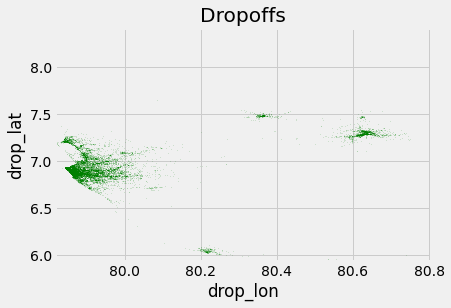

In [0]:
city_long_border = (79.818, 80.8055)
city_lat_border = (5.9366, 8.42173)

train.plot(kind='scatter', x='drop_lon', y='drop_lat',
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.xlim(city_long_border)
plt.ylim(city_lat_border)


(79.818, 80.8055)

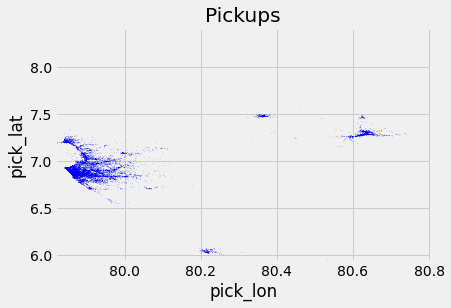

In [0]:
train.plot(kind='scatter', x='pick_lon', y='pick_lat',
                color='blue', 
                s=.02, alpha=.6)
plt.title("Pickups")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

## Drop Negative Values 

In [0]:
# print('Old size: %d' % len(train))
# train = train.dropna(how = 'any', axis = 'rows')
# print('New size: %d' % len(train))

Old size: 16850
New size: 16844


In [0]:
# train['pickup_latitude_round3']=train['pick_lat'].apply(lambda x:round(x,3))
# train['pickup_longitude_round3']=train['pick_lon'].apply(lambda x:round(x,3))
# train['dropoff_latitude_round3']=train['drop_lat'].apply(lambda x:round(x,3))
# train['dropoff_longitude_round3']=train['drop_lon'].apply(lambda x:round(x,3))

In [0]:
# pickup_fare_amount=train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['fare'].mean().reset_index().rename(columns={'fare':'avg_fare'})
# pickup_fare_amount.head()

## Trip Distance

In [0]:
#calculate trip distance in miles
def distance(lat1, lat2, lon1,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [0]:
train['trip_distance']=train.apply(lambda row:distance(row['pick_lat'],row['drop_lat'],row['pick_lon'],row['drop_lon']),axis=1)
test['trip_distance']=test.apply(lambda row:distance(row['pick_lat'],row['drop_lat'],row['pick_lon'],row['drop_lon']),axis=1)

Text(0.5, 1.0, 'Distribution of Trip Distance (log scale)')

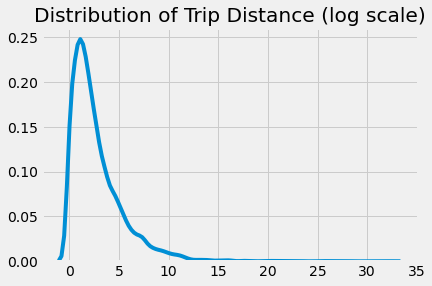

In [0]:
sns.kdeplot(test['trip_distance'].values).set_title("Distribution of Trip Distance (log scale)")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount')

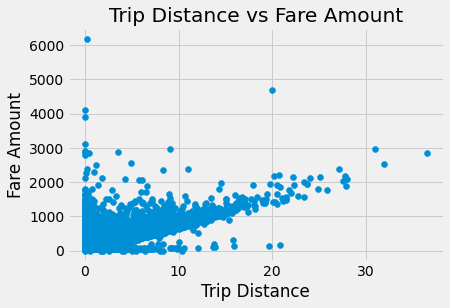

In [0]:
plt.scatter(x=train['trip_distance'],y=train['fare'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount")

# Save to CSV

In [0]:
train.to_csv("features/Train_FeatureEngineering_5_zscore_normalize.csv",index=False)
test.to_csv("features/Test_FeatureEngineering_5_zscore_normalize.csv",index=False)

In [0]:
print (train[train.label == 0].shape[0])

1243


In [0]:
test.head

<bound method NDFrame.head of          tripid  additional_fare  ...  pickup_year  trip_distance
0     213284604  10.5             ...  2020         4.166730     
1     213286352  10.5             ...  2020         25.823263    
2     213293973  10.5             ...  2020         3.676453     
3     213294622  10.5             ...  2020         2.051619     
4     213298687  10.5             ...  2020         1.608445     
...         ...   ...             ...   ...              ...     
8571  222856243  10.5             ...  2020         2.444643     
8572  222857785  10.5             ...  2020         4.671116     
8573  222858416  10.5             ...  2020         1.278300     
8574  222858691  10.5             ...  2020         2.423900     
8575  222860703  10.5             ...  2020         3.377320     

[8576 rows x 20 columns]>